# Training del modello


Dopo aver preparato i dati e definito l'architettura della rete neurale, vado ad addestrare il modello. Durante il training il modello diventerà in grado di riconoscere i pattern e fare previsioni sulle maschere di nuovi dati.

Il processo di training avviene iterativamente per epoche. Per ogni epoca si svolgono le seguenti operazioni:
- viene eseguita la funzione train() sul training set, il modello apprenderà dati, calcolerà la loss e aggiornerà i pesi per minimizzare l'errore;
- viene eseguita la funzione get_evals() sul validation set, cioè vengono calcolate diverse metrice di performance (loss, precision, recall, F1-score) per valutare quanto il modello che sto addestrando è in grado di generalizzare su dati non visti;
- vengono salvate le metriche di valutazione e di training nel dizionario history per monitorare l'andamento delle prestazioni nel tempo;
- viene eseguito un check per prevenire l'overfitting, detto early stopping, che interrompe in anticipo l'addestramento se la loss calcolata sul validation set non migliora o peggiora per un certo numero di iterazioni.

In [1]:
# Let's import our own modules
import sys
sys.path.insert(0, './src')
import utils

import albumentations as A
import os
import torch
import torch.nn as nn
import warnings
import torch.utils.data as data
from rasterio.errors import NotGeoreferencedWarning

Verifico che la GPU sia disponibile e che CUDA funzioni.

In [2]:
device = utils.set_cuda_and_seed()

print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())

Using PyTorch version: 2.7.1+cu118  Device: cuda
PyTorch version:  2.7.1+cu118
CUDA version:  11.8
cuDNN version:  90100


Costanti utili e percorsi utili

In [ ]:
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
INITIAL_LR = 1e-4
MAX_LR = 1e-2
SIZE = 200
NUM_WORKERS = 8
BATCH_SIZE = 16
EPOCHS = 16
LOAD_BEST = False

# Percorsi utili
DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"
SPLIT_PATH = "split/"

Preparo i dati e faccio data augmentation prima di iniziare ad addestrare la rete. Utilizzo la libreria Albumentations, come suggerito dal tutor, che è molto efficiente nelle trasformazioni delle immagini.

Per il training set vado a fare una normalizzazione dei pixel delle immagini e poi vado a fare dei Random Resized Crop, cioè faccio selezionare una porzione casuale dell'immagine, che viene poi ridimensionata alla dimensione SIZE.

Per il validation set vado a fare una normalizzazione dei pixel delle immagini e poi vado a fare dei Center Crop, cioè faccio selezionare una porzione quadrata di lato SIZE dal centro dell'imagine.

Infine vado a caricare le immagini e le maschere del dataset, applicandovi le trasformazioni definite nella stessa cella.

In [4]:
train_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.RandomResizedCrop(size = (SIZE, SIZE)),
])

eval_transforms = A.Compose([
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    A.CenterCrop(SIZE, SIZE)
])

from dataset import SN6Dataset

train_dataset = SN6Dataset(SPLIT_PATH, transform=train_transforms, split='train')
eval_dataset = SN6Dataset(SPLIT_PATH, transform=eval_transforms, split='val')

Vado a caricare sui loader i valori necessari per l'addestramento che sono i dataset, le dimensioni dei batch, la funzione shuffle per mescolare i dati, la variabile pin_memory così che PyTorch tenta di caricare i tensori nella memoria "pinnata" (pinned memory) della RAM e il numero di sottoprocessi da utilizzare per il caricamento dei dati.
Infine faccio un check di prova stampando un'immagine casuale e la rispettiva maschera.

Image shape: torch.Size([16, 3, 200, 200]), Mask shape: torch.Size([16, 1, 200, 200])


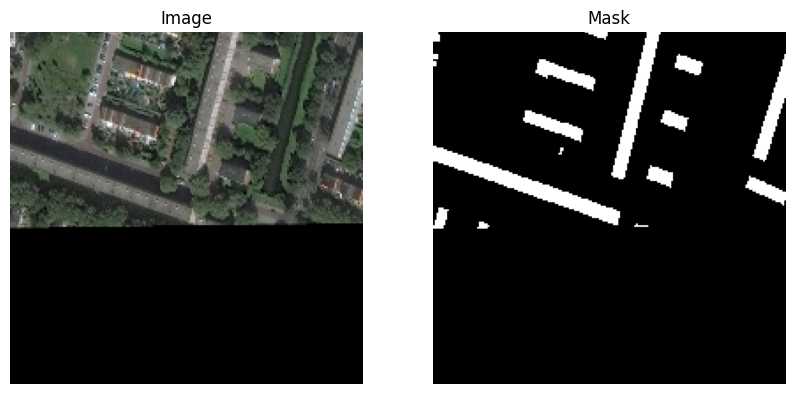

In [7]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

    train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
    eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True, num_workers=NUM_WORKERS)

    image, mask = next(iter(train_loader))
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
    utils.visualize_image(image[0], mask[0])

In [8]:
mean, std = utils.get_mean_std("split/train.txt")
print("Mean: ", mean)
print("Std: ", std) 

Using device: cuda


Calculating mean and std: 100%|██████████| 2720/2720 [00:18<00:00, 148.94it/s]

Mean:  [63.31486282 66.9413639  60.9381894 ]
Std:  [55.64725704 55.50469196 52.78288904]


Importo il modello che contiene la rete e vado a stabilire diversi parametri necessari, come la funzione di loss da utilizzare, il tipo di ottimizzatore da utilizzare e se utilizzare uno scaler.

In [9]:
from model import UNET
from train import train

model = UNET(in_channels = 3, out_channels = 1).to(device)

criterion = nn.BCEWithLogitsLoss() # first we'll use BCEWithLogitsLoss, then we'll try with L1Loss since it's the best metric for the homework
optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)

# We won't use a scheduler at first, but we'll add it later
# torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS, anneal_strategy='cos')
scheduler = None
scaler = torch.amp.GradScaler('cuda', enabled=True)

Avvio il training del mio modello.

In [ ]:
best_f1 = 0.0
history = {
    'train_loss': [],
    'val_loss': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'accuracy': [],
    'dice' : []
}

last_epoch = 0
if LOAD_BEST:
    print("Restoring best model")
    if(os.path.exists(CHECKPOINT_PATH + "best.pth")):
        history, last_epoch = utils.load_checkpoint(CHECKPOINT_PATH + "best.pth", model, optimizer, scheduler)
        best_f1 = max(history['f1'])
    else:
        print("Best model not found, starting from scratch")


# Ciclo di traininig
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    for epoch in range(last_epoch, EPOCHS):
        print(f"Epoch {epoch+1} of {EPOCHS}")
        train_loss = train(train_loader, model, optimizer, criterion, scaler, scheduler, device)
        # Se la loss è NaN, vuol dire che qualcosa non sta andando come previsto, vado quindi ad interrompere il training
        if train_loss != train_loss:
            raise ValueError("La loss è Nan, qualcosa sta andando storto, interrompo il training!")

        eval_loss, precision, recall, f1, accuracy = utils.get_evals(eval_loader, model, criterion, device, save_predictions=True, output_path="data/eval")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(eval_loss)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)
        history['accuracy'].append(accuracy)
        print(f"Train loss: {train_loss:.4f} Eval loss: {eval_loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f} Accuracy: {accuracy:.4f}")
        # Salvataggio del checkpoint
        checkpoint = {
            "history" : history,
            "epoch" : epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": criterion.state_dict(),
        }
        utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "checkpoint.pth")
        if f1 > best_f1:
            best_f1 = f1
            utils.save_checkpoint(checkpoint, filename=CHECKPOINT_PATH + "best.pth")
            print("Best model salvato")

        if epoch - 3 > 0: # Value of validation loss is increasing, model is overfitting. Need to stop training
            if history['val_loss'][epoch] > history['val_loss'][epoch-1] > history['val_loss'][epoch-2]:
                print("Early stopping")
                break
print("Training completato con successo!")

Epoch 1 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.4025 Eval loss: 0.3669 Precision: 0.5207 Recall: 0.5747 F1: 0.5463 Accuracy: 0.8990
saving checkpoint
saving checkpoint
Best model saved
Epoch 2 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.2847 Eval loss: 0.2950 Precision: 0.6739 Recall: 0.4903 F1: 0.5676 Accuracy: 0.9210
saving checkpoint
saving checkpoint
Best model saved
Epoch 3 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.2349 Eval loss: 0.2654 Precision: 0.7721 Recall: 0.3852 F1: 0.5140 Accuracy: 0.9229
saving checkpoint
Epoch 4 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.1923 Eval loss: 0.2174 Precision: 0.7635 Recall: 0.5012 F1: 0.6051 Accuracy: 0.9308
saving checkpoint
saving checkpoint
Best model saved
Epoch 5 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.1677 Eval loss: 0.2416 Precision: 0.6017 Recall: 0.5875 F1: 0.5945 Accuracy: 0.9152
saving checkpoint
Epoch 6 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.1462 Eval loss: 0.1924 Precision: 0.6996 Recall: 0.6448 F1: 0.6711 Accuracy: 0.9331
saving checkpoint
saving checkpoint
Best model saved
Epoch 7 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.1305 Eval loss: 0.1833 Precision: 0.7971 Recall: 0.5384 F1: 0.6427 Accuracy: 0.9367
saving checkpoint
Epoch 8 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.1233 Eval loss: 0.1851 Precision: 0.7388 Recall: 0.5352 F1: 0.6207 Accuracy: 0.9308
saving checkpoint
Epoch 9 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.1118 Eval loss: 0.1788 Precision: 0.8603 Recall: 0.4512 F1: 0.5919 Accuracy: 0.9342
saving checkpoint
Epoch 10 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.1037 Eval loss: 0.1449 Precision: 0.7700 Recall: 0.6849 F1: 0.7250 Accuracy: 0.9450
saving checkpoint
saving checkpoint
Best model saved
Epoch 11 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.0980 Eval loss: 0.1689 Precision: 0.7137 Recall: 0.6779 F1: 0.6953 Accuracy: 0.9372
saving checkpoint
Epoch 12 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.0951 Eval loss: 0.1600 Precision: 0.7209 Recall: 0.6914 F1: 0.7058 Accuracy: 0.9390
saving checkpoint
Epoch 13 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.0889 Eval loss: 0.1397 Precision: 0.7906 Recall: 0.7047 F1: 0.7452 Accuracy: 0.9490
saving checkpoint
saving checkpoint
Best model saved
Epoch 14 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.0829 Eval loss: 0.1673 Precision: 0.7440 Recall: 0.6262 F1: 0.6801 Accuracy: 0.9377
saving checkpoint
Epoch 15 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.0821 Eval loss: 0.1389 Precision: 0.8005 Recall: 0.6538 F1: 0.7198 Accuracy: 0.9461
saving checkpoint
Epoch 16 of 16


  0%|          | 0/170 [00:00<?, ?it/s]/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivan

Saving predictions to: data/eval



/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sen

Train loss: 0.0773 Eval loss: 0.1405 Precision: 0.8424 Recall: 0.6259 F1: 0.7182 Accuracy: 0.9480
saving checkpoint
Finished training! Well done :3
Quitting...


Vado infine a stampare un esempio di predizione e di ground truth (maschera effettiva). Seguono i grafici sull'andamento della funzione di loss e delle varie metriche di valutazione, all'aumentare delle epoche passate.

loading checkpoint


/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sensing-SpaceNet6/.venv/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/moraz/Scrivania/Remote Sensing SpaceNet6/Remote-Sens

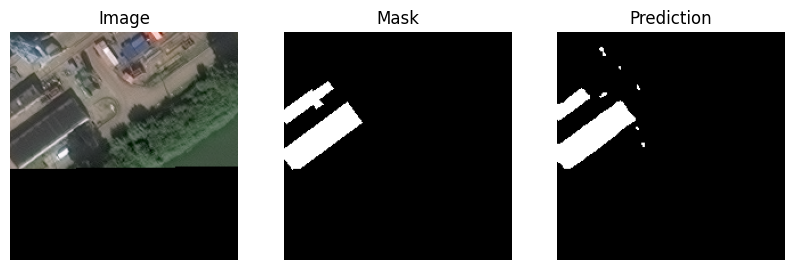

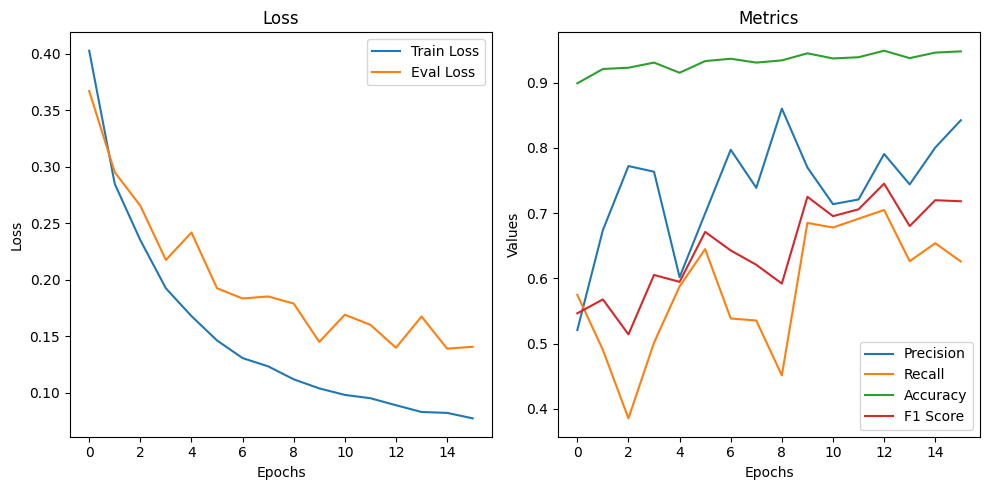

In [ ]:
import matplotlib.pyplot as plt

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    
    # Visualizzazione di un esempio di predizione e ground truth
    history = utils.load_checkpoint(CHECKPOINT_PATH + "checkpoint.pth", model)
    image, mask, pred = utils.get_random_image(eval_loader, model, device)
    utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = GRAPH_PATH + "baseline.png")

    train_loss = history['train_loss']
    eval_loss = history['val_loss']
    precision = history['precision']
    recall = history['recall']
    accuracy = history['accuracy']
    f1_score = history['f1']
    # Grafico della loss e delle altre metriche di valutazione
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Loss')   
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_loss, label='Train Loss')
    plt.plot(eval_loss, label='Eval Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Metriche di valutazione')
    plt.xlabel('Epochs')
    plt.ylabel('Values')
    plt.plot(precision, label='Precision')
    plt.plot(recall, label='Recall')
    plt.plot(accuracy, label='Accuracy')
    plt.plot(f1_score, label='F1 Score')
    plt.legend()
    plt.tight_layout()
    plt.savefig(GRAPH_PATH + "metrics_baseline.png")
    plt.show()